In [1]:
from tensorflow import keras
from keras.layers import Dense, Dropout,Flatten,Conv2D, MaxPooling2D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import datetime
import numpy as np
import os
import cv2

- Première version du modèle (celui d'origine) : 
  - data
  - score `[0.09560658782720566, 0.9682080745697021]`
- Seconde version du modèle : 
  - Ajout de d'image lié aux polices + des boxes de sudoku
  - 9539 images dont 7631 pour le train
  - loss: 0.0654 - accuracy: 0.9800 - val_loss: 0.1068 - val_accuracy: 0.9706
  - score `[0.10683777928352356, 0.9706498980522156]`
- 3ème version du modèle :
  - Ajout des boxes de sudoku récupéré via la caméra
  - 10187 images dont 8149 pour le train
  - score : `[0.1491367071866989, 0.9587831497192383]`
  - `{0: 1173, 1: 1149, 2: 1171, 3: 969, 4: 993, 5: 961, 6: 908, 7: 1043, 8: 889, 9: 931}`
- 4ème version du modèle :
  - Ajout des boxes de sudoku récupéré via la caméra
  - 10523 images dont 8418 pour le train
  - score : `[0.16389647126197815, 0.9586698412895203]`
  - `{0: 1173, 1: 1187, 2: 1213, 3: 1014, 4: 1034, 5: 1001, 6: 945, 7: 1070, 8: 922, 9: 964}`


In [2]:
X = []
y = []
heightImg = 28
widhtImg = 28

for i in range(0, 10):
    for d in os.listdir("../dataset/digits/{}".format(i)):
        t_img = cv2.imread("../dataset/digits/{}".format(i)+"/"+d)
        t_img = cv2.cvtColor(t_img,cv2.COLOR_BGR2GRAY)
        img = cv2.resize(t_img, (heightImg,widhtImg))
        X.append(img)
        y.append(i)

In [3]:
X = np.array(X)
y = np.array(y)

In [4]:
from collections import Counter
count_ = Counter(y)
count_

Counter({0: 1173,
         1: 1187,
         2: 1213,
         3: 1014,
         4: 1034,
         5: 1001,
         6: 945,
         7: 1070,
         8: 922,
         9: 964})

In [5]:
print(X.shape)
y.shape

(10523, 28, 28)


(10523,)

In [6]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state= 21)

In [7]:
X_train.shape

(8418, 28, 28)

In [8]:
y_test

array([0, 3, 1, ..., 2, 7, 8])

In [9]:
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1]

In [10]:
num_classes

10

In [11]:
def larger_model():
    # create model
	model = keras.Sequential(
    [
        Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'),
        MaxPooling2D(),
        Conv2D(15, (3, 3), activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(50, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    

    # Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model


In [12]:
model = larger_model()
log_dir = r"C:/Users/User/WORK/workspace-ia/PROJETS/projet_sudoku/model/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [13]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=10,callbacks=[tensorboard_callback])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)

print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
842/842 [==============================] - 11s 13ms/step - loss: 1.1807 - accuracy: 0.5915 - val_loss: 0.5577 - val_accuracy: 0.8461
Epoch 2/10
842/842 [==============================] - 5s 6ms/step - loss: 0.5021 - accuracy: 0.8440 - val_loss: 0.3940 - val_accuracy: 0.8931
Epoch 3/10
842/842 [==============================] - 5s 6ms/step - loss: 0.3332 - accuracy: 0.8988 - val_loss: 0.2777 - val_accuracy: 0.9287
Epoch 4/10
842/842 [==============================] - 5s 6ms/step - loss: 0.2643 - accuracy: 0.9184 - val_loss: 0.2506 - val_accuracy: 0.9235
Epoch 5/10
842/842 [==============================] - 5s 6ms/step - loss: 0.1942 - accuracy: 0.9408 - val_loss: 0.2052 - val_accuracy: 0.9496
Epoch 6/10
842/842 [==============================] - 5s 6ms/step - loss: 0.1696 - accuracy: 0.9468 - val_loss: 0.2245 - val_accuracy: 0.9449
Epoch 7/10
842/842 [==============================] - 5s 5ms/step - loss: 0.1485 - accuracy: 0.9545 - val_loss: 0.1729 - val_accuracy: 0.9553
Epoc

In [14]:
# V1 : [0.09560658782720566, 0.9682080745697021]
# V2 : [0.10683777928352356, 0.9706498980522156]
# V3 : [0.1491367071866989, 0.9587831497192383]
scores

[0.16389647126197815, 0.9586698412895203]

In [15]:
pred = model.predict(X_test,verbose = 1)
pred_classes = []

for p in pred:
    classIndex = np.argmax(p)
    probabilityValue = np.amax(p)
    
    if probabilityValue > 0.65:
        pred_classes.append(classIndex)
    else:
        pred_classes.append(0)
pred_classes

66/66 [==============================] - 1s 6ms/step


[0,
 3,
 1,
 2,
 0,
 5,
 1,
 2,
 9,
 5,
 9,
 5,
 6,
 0,
 5,
 4,
 5,
 6,
 7,
 0,
 1,
 8,
 4,
 3,
 5,
 5,
 5,
 1,
 3,
 1,
 7,
 0,
 8,
 4,
 0,
 6,
 2,
 0,
 8,
 5,
 9,
 9,
 6,
 7,
 4,
 1,
 1,
 2,
 0,
 0,
 9,
 5,
 5,
 6,
 0,
 5,
 0,
 9,
 5,
 7,
 9,
 0,
 6,
 0,
 6,
 6,
 2,
 3,
 4,
 1,
 1,
 7,
 0,
 8,
 8,
 5,
 7,
 1,
 8,
 3,
 1,
 6,
 9,
 3,
 0,
 8,
 8,
 6,
 0,
 7,
 1,
 9,
 3,
 8,
 2,
 1,
 2,
 8,
 7,
 0,
 4,
 1,
 6,
 2,
 8,
 2,
 2,
 1,
 2,
 4,
 6,
 8,
 5,
 4,
 1,
 3,
 2,
 0,
 4,
 6,
 1,
 0,
 0,
 1,
 3,
 9,
 0,
 1,
 1,
 0,
 5,
 4,
 2,
 0,
 4,
 2,
 2,
 1,
 2,
 7,
 7,
 3,
 4,
 8,
 0,
 4,
 0,
 2,
 3,
 9,
 6,
 4,
 0,
 9,
 2,
 5,
 3,
 9,
 2,
 4,
 9,
 3,
 2,
 1,
 0,
 7,
 2,
 6,
 2,
 4,
 8,
 7,
 7,
 4,
 1,
 4,
 0,
 9,
 1,
 5,
 6,
 0,
 1,
 3,
 3,
 5,
 5,
 9,
 6,
 7,
 2,
 0,
 1,
 5,
 7,
 9,
 6,
 5,
 3,
 1,
 8,
 3,
 9,
 6,
 0,
 0,
 2,
 5,
 8,
 9,
 1,
 8,
 5,
 2,
 5,
 3,
 2,
 0,
 1,
 1,
 5,
 9,
 2,
 2,
 6,
 2,
 9,
 4,
 0,
 4,
 1,
 8,
 4,
 3,
 0,
 0,
 1,
 4,
 2,
 6,
 5,
 2,
 1,
 5,
 0,
 1,
 5,
 2,
 8,
 9,


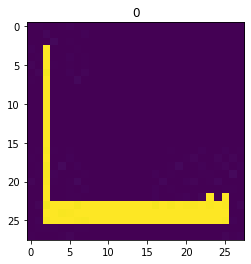

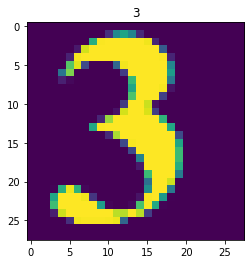

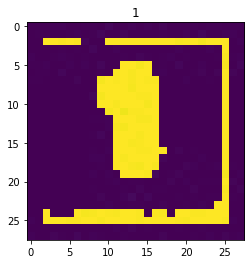

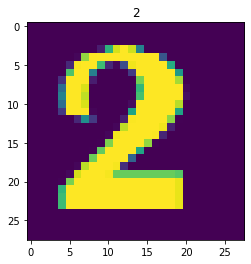

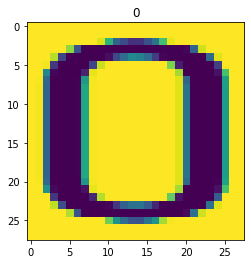

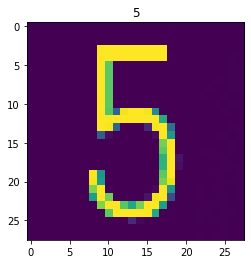

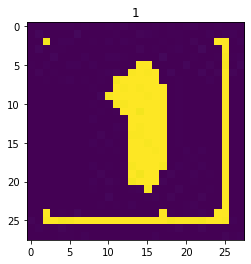

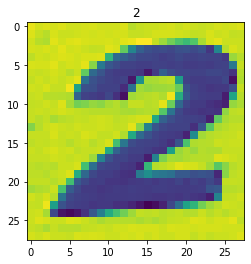

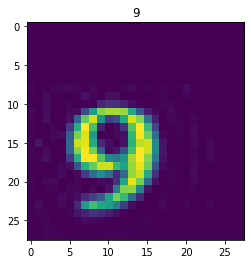

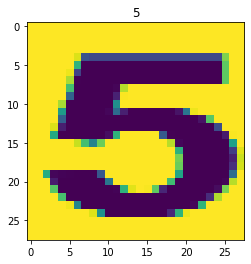

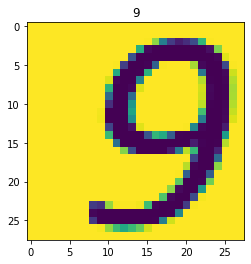

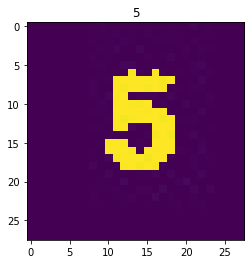

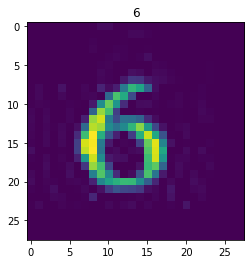

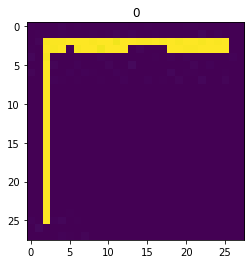

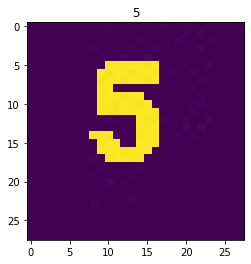

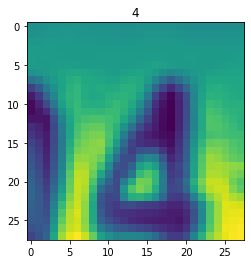

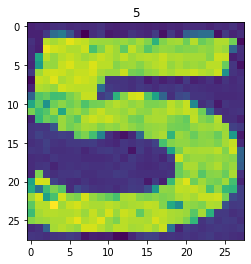

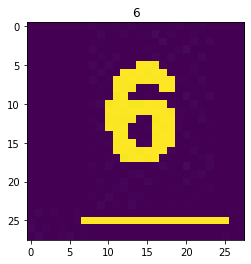

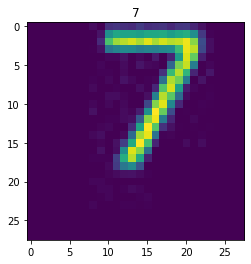

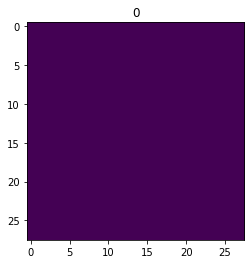

In [16]:
import matplotlib.pyplot as plt

for i in range(20):
    
    plt.imshow(X_test[i])
    plt.title(pred_classes[i])
    plt.show()

In [17]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 34160), started 1 day, 19:31:28 ago. (Use '!kill 34160' to kill it.)

In [18]:
model.save(r"C:\Users\User\WORK\workspace-ia\PROJETS\projet_sudoku\model\aurao-V4")

INFO:tensorflow:Assets written to: C:\Users\User\WORK\workspace-ia\PROJETS\projet_sudoku\model\aurao-V4\assets


INFO:tensorflow:Assets written to: C:\Users\User\WORK\workspace-ia\PROJETS\projet_sudoku\model\aurao-V4\assets
